In [1]:
import pickle
import numpy as np

from utils.lang_enum import languages

DF_CACHE_PATH = "../../datasets/cache/all.pickle"
DF_PATHONLY_CACHE_PATH = "../../datasets/cache/path_only.pickle"

# Validate

In [1]:
import train as mt

MODEL_RESUME = "./logs/l_2023-11-19_10-55-23_bs=1024_epochs=130/epoch=59-step=147960.ckpt"
model = mt.LanguageClassifier.load_from_checkpoint(MODEL_RESUME, strict=False).model.cpu().eval()
# model = mt.LanguageClassifier().cpu().eval()

Global seed set to 9
/home/smr/anaconda3/envs/optiver/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:165: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['ce_loss.weight']
  rank_zero_warn(


In [2]:
import pickle
df = pickle.load(open(DF_PATHONLY_CACHE_PATH, "rb"))

def load_file(filepath):
    with open(filepath, "r") as f:
        return f.read()

test_df = df[df.source.isin(mt.TEST_SOURCES)]

NameError: name 'DF_PATHONLY_CACHE_PATH' is not defined

In [ ]:
from typing import List
from utils import vocab

import random
import torch
from utils import helper, preprocess, lang_enum

tdf = test_df
lang = random.choice(tdf.language_tag.unique().tolist())
sample = tdf[(tdf.language_tag == lang)].sample()
text = helper.augment(load_file(sample.path.iloc[0]), lines_num_range=(5, 50))
source = sample.source.iloc[0]
# text = """
# """

data = preprocess.encode_text(text.lower()[:vocab.max_size])
data = [torch.tensor(c).unsqueeze(0).long() for c in data]
encoded_text, naming_types, group_types, line_numbers, positions = data

lang_logits, other_logits, _, _ = model(encoded_text, naming_types, group_types, line_numbers, positions)
lang_logits = lang_logits.softmax(1)
is_other_prob = other_logits.softmax(1)[:, 0]

print(f"gt: {lang} [{source}]")
top = 2
t5 = lang_logits.topk(top)
for i in range(top):
    print(f"{lang_enum.languages[t5.indices[0][i].item()]}: {t5.values[0][i].item():.2f}")
print(f"IS_OTHER: {is_other_prob.item():.2f}")
print("-"*10 + "ORIGINAL TEXT" + "-"*10)
print(text)
print("-"*10 + "DECODED TOKENS" + "-"*10)
print(preprocess.decode_text(encoded_text.tolist()[0]))

gt: TGLANG_LANGUAGE_NGINX [llama_tasks]
TGLANG_LANGUAGE_NGINX: 0.97
TGLANG_LANGUAGE_OTHER: 0.02
IS_OTHER: 0.01
----------ORIGINAL TEXT----------
  image {
    // Use a CDN for images
    proxy_pass http://images.example.com;
    // Use a specific cache control for images
    add_header Cache-Control "public, max-age=31536000";
    // Serve the image from the CDN if it exists
    if (file_exists ($document_root / $request_filename)) {
      root $document_root;
    } else {
      error 404 /404.html;
    }
  }
----------DECODED TOKENS----------
image {
  // use a cdn for images
  proxy_pass http://images.example.com;
  // use a specific cache control for images
  add_header cache-control "public, max-age=31536000";
  // serve the image from the cdn if it exists
  if (file_exists ($document_root / $request_filename)) {
    root $document_root;
  } else {
    error 404 /404.html;
  }
}


# Run full ds

In [4]:
from utils import lang_enum
from utils.dataset import CodeDataset
import train as mt

DF_PATHONLY_CACHE_PATH = "../../datasets/cache/path_only.pickle"
MODEL_RESUME = "./logs/l_2023-11-20_07-48-39_bs=1024_epochs=130/epoch=82-step=176319.ckpt"
# MODEL_RESUME = "./logs/l_2023-11-19_10-55-23_bs=1024_epochs=130/epoch=98-step=190503.ckpt"
model = mt.LanguageClassifier.load_from_checkpoint(MODEL_RESUME, strict=False).cuda().eval()
# model = mt.LanguageClassifier().cpu().eval()

import pickle
df = pickle.load(open(DF_PATHONLY_CACHE_PATH, "rb"))
df["language_id"] = df["language_tag"].map(lang_enum.languages2num)

def load_file(filepath):
    with open(filepath, "r") as f:
        return f.read()

test_df = df[df.source.isin(mt.TEST_SOURCES)]

from torch.utils.data import DataLoader, Dataset

dataset = CodeDataset(test_df, aug=False)
test_loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=32, collate_fn=mt.CodeDataset.collate_fn)

/home/smr/anaconda3/envs/optiver/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:165: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['ce_loss.weight']
  rank_zero_warn(
/home/smr/workspace/comp/tg/playground/train/utils/dataset.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["language_id"] = df["language_tag"].map(lang_enum.languages2num)


In [5]:
import tqdm.autonotebook as tqdm

all_preds = []
all_probs = []
all_is_other_probs = []

for batch in tqdm.tqdm(test_loader):
    inputs, naming_types, group_types, lines_num, positions, _, attention_masks = batch
    y_hat, is_other, _, _ = model(inputs.cuda(), naming_types.cuda(), group_types.cuda(),
                                  lines_num.cuda(), positions.cuda(), attention_masks.cuda())

    probs = y_hat.softmax(dim=1)
    pred_labels = probs.argmax(dim=1)
    is_other_probs = is_other.softmax(dim=1)[:, 0]

    for p, l, o in zip(probs, pred_labels, is_other_probs):
        all_preds.append(l.item())
        all_probs.append(p[l].item())
        all_is_other_probs.append(o.item())

test_df.loc[:, "pred"] = all_preds
test_df.loc[:, "prob"] = all_probs
test_df.loc[:, "is_other_prob"] = all_is_other_probs

import gc
_ = gc.collect()

  0%|          | 0/820 [00:00<?, ?it/s]

/tmp/ipykernel_3451222/1636351740.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, "pred"] = all_preds
/tmp/ipykernel_3451222/1636351740.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, "prob"] = all_probs
/tmp/ipykernel_3451222/1636351740.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

### Visualise accuracy

prob_threshold: 0.48
avg_accuracy   0.941593
--------------------
source
cpp_test       0.971200
llama_tasks    0.880639
rosetta        0.934375
tgdataset      0.959012
tgdataset2     0.960237
--------------------


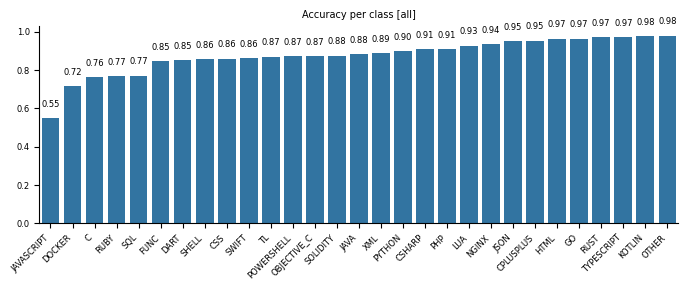

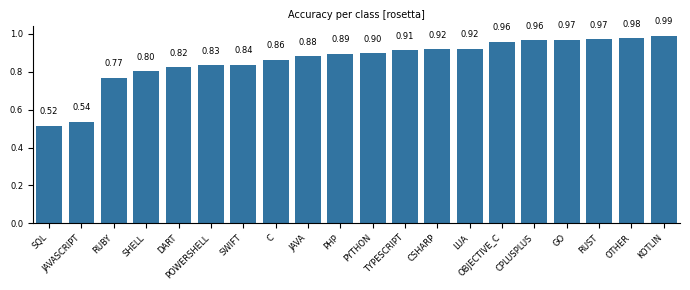

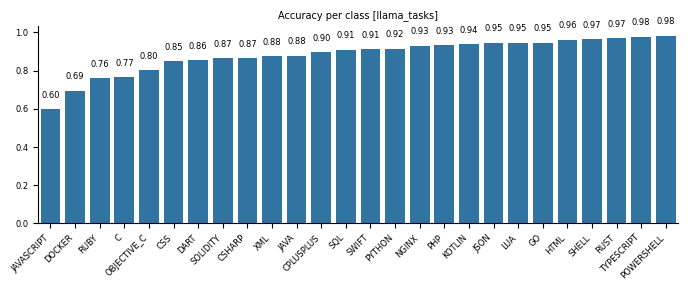

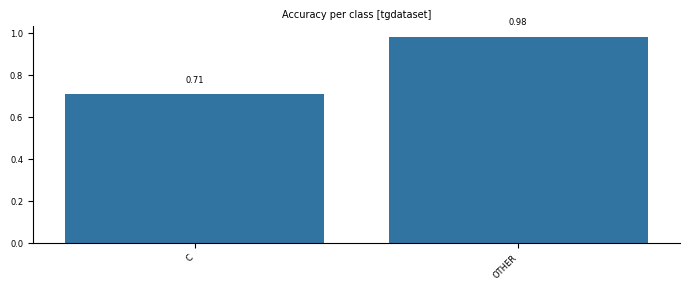

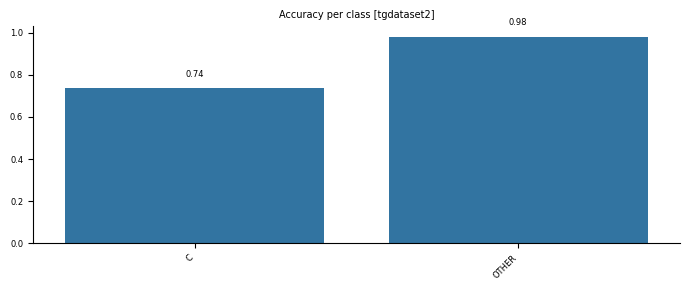

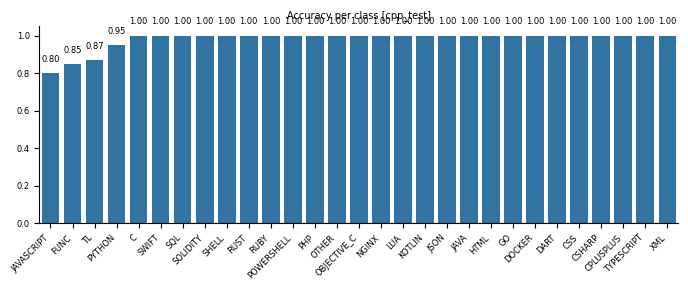

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def find_optimal_thresholds(tdf):
    best_threshold_1 = None
    best_accuracy = 0

    for threshold_1 in np.arange(0.1, 0.9, 0.01):
        ttdf = tdf.copy()
        ttdf.loc[ttdf['prob'] < threshold_1, 'pred'] = 0
        # ttdf.loc[ttdf['is_other_prob'] > threshold_2, 'pred'] = 0

        avg_accuracy = (ttdf['language_id'] == ttdf['pred']).mean()

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_threshold_1 = threshold_1

    return best_threshold_1


tdf = test_df.copy()
tdf.loc[(tdf.source == "tgdataset") & (tdf["pred"]>1), "pred"] = 1
tdf.loc[(tdf.source == "tgdataset2") & (tdf["pred"]>1), "pred"] = 1
t1 = find_optimal_thresholds(tdf)
print(f"prob_threshold: {t1:.2f}")
tdf.loc[tdf["prob"]<t1, "pred"] = 0
# tdf.loc[tdf["is_other_prob"]>t2, "pred"] = 0
# tdf.loc[(tdf["prob"] + (1-tdf["is_other_prob"])) / 2 < 0.2, "pred"] = 0

avg_accuracy = (tdf.language_id == tdf.pred).mean()
print(f"avg_accuracy   {avg_accuracy:.6f}")
print("--------------------")

per_source_accuracy = tdf[tdf.language_id == tdf.pred].groupby("source").size() / tdf.groupby("source").size()
print(per_source_accuracy.to_string())
print("--------------------")

def plot_per_class(tdf, source_name=""):
    per_class_accuracy = tdf[tdf.language_id == tdf.pred].groupby("language_tag").size() / tdf.groupby("language_tag").size()
    per_class_accuracy = per_class_accuracy.sort_values(ascending=True)

    labels = [v[16:] for v in per_class_accuracy.index.tolist()]
    plt.figure(figsize=(7, 3))
    ax = sns.barplot(x=labels, y=per_class_accuracy.values)
    ax.set_title(f'Accuracy per class [{source_name}]', fontsize=7)
    plt.xticks(rotation=45, ha='right', fontsize=6)
    plt.yticks(fontsize=6)
    sns.despine()
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=6)

    plt.tight_layout()
    plt.show()

plot_per_class(tdf, "all")
for source in mt.TEST_SOURCES:
    plot_per_class(tdf[tdf.source == source], source)

# avg_accuracy   0.942146
# --------------------
# source
# cpp_test       0.974400
# llama_tasks    0.885695
# rosetta        0.935960
# tgdataset      0.957356
# tgdataset2     0.959035
# --------------------

### Find worst

In [38]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import Layout

# wdf = test_df[test_df.pred != test_df.language_id]
wdf = tdf[tdf.pred != tdf.language_id]
wdf = wdf.sample(frac=1)

# subset
# wdf = wdf[wdf.source == "cpp_test"]
wdf = wdf[wdf.source == "llama_tasks"]
# wdf = wdf[wdf.source == "tgdataset2"]
# wdf = wdf[wdf.source == "rosetta"]
# wdf = wdf[wdf.source == "tgdataset"]
# wdf = wdf[wdf.language_tag == "TGLANG_LANGUAGE_RUBY"]
# wdf = wdf[wdf.language_tag == "TGLANG_LANGUAGE_JAVASCRIPT"]
wdf = wdf[wdf.language_tag == "TGLANG_LANGUAGE_SQL"]


file_counter = 0
excluded_paths = []

file_content = widgets.Textarea(value='', placeholder='File content will be shown here', description='', disabled=True, layout=widgets.Layout(width='100%', height='300px'))

info_label = widgets.Label(value="Select a file to view details")

def update_display():
    global file_counter
    if file_counter >= len(wdf):
        file_counter = 0
    elif file_counter < 0:
        file_counter = len(wdf) - 1

    row = wdf.iloc[file_counter]
    path, gt, pred, prob = row['path'], row['language_id'], row['pred'], row['prob']
    source = row['source']
    content = load_file(path)
    file_content.value = content
    info_label.value = f"{source}: {lang_enum.languages[gt][16:]} | pred: {lang_enum.languages[pred][16:]} [{prob:.2f}]"

def mark_wrong(b=None):
    global file_counter
    path = wdf.iloc[file_counter]['path']
    excluded_paths.append(path)
    file_counter += 1
    update_display()

def next_file(b=None):
    global file_counter
    file_counter += 1
    update_display()

def prev_file(b=None):
    global file_counter
    file_counter -= 1
    update_display()

mark_wrong_button = widgets.Button(description='Mark Wrong', button_style='danger')
mark_wrong_button.on_click(mark_wrong)

next_button = widgets.Button(description='Next File')
next_button.on_click(next_file)

prev_button = widgets.Button(description='Previous File')
prev_button.on_click(prev_file)

update_display()

display(info_label, file_content, widgets.HBox([prev_button, mark_wrong_button, next_button]))

Label(value='llama_tasks: SQL | pred: OTHER [0.60]')

Textarea(value="SELECT * FROM tables (\n   -- Use a nested SELECT statement within a subquery\n    SELECT * FR…

In [10]:
len(excluded_paths), len(list(set(excluded_paths)))

(130, 96)

In [34]:
update_path = "../../datasets/excluded_paths.txt"
with open(update_path, "w+") as f:
    f.write("\n".join(excluded_paths))

# Export

In [1]:
# GENERATE MODEL_META.HPP

from utils import vocab

def escape_string(s):
    return s.replace('\\', '\\\\').replace('\n', '\\n').replace('\t', '\\t').replace('"', r'\"')

prob_threshold = 0.48
# is_code_threshold = 0.15

def generate_cpp_header(strings):
    header_content = "#pragma once\n\n"
    header_content += "#include <vector>\n"
    header_content += "#include <unordered_map>\n"
    header_content += "#include <string>\n\n"

    max_len = max([len(s) for s in strings])
    header_content += "const int MODEL_MAX_INPUT = " + str(vocab.max_size) + ";\n"
    header_content += "const int MODEL_MAX_LINES_NUM = " + str(vocab.max_lines_num) + ";\n"
    header_content += f"const float DETECTION_THRESHOLD = {prob_threshold};\n"
    header_content += "const int VOCAB_NEW_LINE_ID = " + str(vocab.vocab_dict["\n"]) + ";\n"
    header_content += "const int VOCAB_UNK_ID = " + str(len(vocab.vocab_list) - 1) + ";\n"
    header_content += "const int VOCAB_PAD_ID = " + str(len(vocab.vocab_list) - 2) + ";\n"
    header_content += "const int VOCAB_MAX_LEN = " + str(max_len) + ";\n\n"
    header_content += "using det_int_t = int64_t;\n\n"

    header_content += "const std::vector<std::string> vocab_list = {\n"
    for s in strings:
        header_content += '    "' + escape_string(s) + '",\n'
    header_content += "};\n\n"

    vocab_map = {s: i for i, s in enumerate(strings)}
    header_content += "const std::unordered_map<std::string, det_int_t> vocab_map = {\n"
    for s, i in vocab_map.items():
        header_content += '    {"' + escape_string(s) + '", ' + str(i) + '},\n'
    header_content += "};\n\n"

    return header_content

header = generate_cpp_header(vocab.vocab_list)
with open("../src/data/model/model_meta.hpp", 'w') as f:
    f.write(header)

In [1]:
import os
import numpy as np
import tqdm
import torch
import torch.onnx

import tensorflow as tf

import utils.convert_tools as ct
import utils.vocab as vocab
from model import tf_tglang, tglang

import train as tglang_train

def convert_TGLangAttention(torch_layer, tf_layer):
    ct.convert_Linear(torch_layer.k_proj, tf_layer.k_proj)
    ct.convert_Linear(torch_layer.v_proj, tf_layer.v_proj)
    ct.convert_Linear(torch_layer.q_proj, tf_layer.q_proj)
    ct.convert_Linear(torch_layer.out_proj, tf_layer.out_proj)

def convert_TGLangFeedForward(torch_layer, tf_layer):
    ct.convert_Linear(torch_layer.intermediate_dense, tf_layer.intermediate_dense)
    ct.convert_Linear(torch_layer.output_dense, tf_layer.output_dense)

def convert_TGLangEncoderLayer(torch_layer, tf_layer):
    convert_TGLangAttention(torch_layer.attention, tf_layer.attention)
    convert_TGLangFeedForward(torch_layer.feed_forward, tf_layer.feed_forward)
    ct.convert_LayerNorm(torch_layer.final_layer_norm, tf_layer.final_layer_norm)

def convert_TGLangTransformerEncoder(torch_layer, tf_layer):
    for torch_enc_layer, tf_enc_layer in zip(torch_layer.layers, tf_layer.layers):
        convert_TGLangEncoderLayer(torch_enc_layer, tf_enc_layer)

def convert_TGLangConvBlock(torch_layer, tf_layer):
    ct.convert_Conv1D(torch_layer.conv, tf_layer.conv)
    if torch_layer.use_ln:
        ct.convert_LayerNorm(torch_layer.ln, tf_layer.ln)
    if torch_layer.use_bn:
        ct.convert_BatchNorm(torch_layer.bn, tf_layer.bn)

def convert_TGLangConvEncoder(torch_layer, tf_layer):
    for i in range(len(torch_layer.encoder)):
        convert_TGLangConvBlock(torch_layer.encoder[i], tf_layer.encoder.layers[i])
    convert_TGLangConvBlock(torch_layer.word_conv, tf_layer.word_conv)
    convert_TGLangConvBlock(torch_layer.structure_conv, tf_layer.structure_conv)
    convert_TGLangConvBlock(torch_layer.conv_bottleneck, tf_layer.conv_bottleneck)
    convert_TGLangConvBlock(torch_layer.final_conv, tf_layer.final_conv)

def convert_TGLangWordEmbeddings(torch_layer, tf_layer):
    ct.convert_Embedding(torch_layer.word_embeddings, tf_layer.word_embeddings)
    ct.convert_Embedding(torch_layer.position_embeddings, tf_layer.position_embeddings)

def convert_TGLangStructureEmbeddings(torch_layer, tf_layer):
    ct.convert_Embedding(torch_layer.naming_type_embeddings, tf_layer.naming_type_embeddings)
    ct.convert_Embedding(torch_layer.group_type_embeddings, tf_layer.group_type_embeddings)
    ct.convert_Embedding(torch_layer.lines_num_embeddings, tf_layer.lines_num_embeddings)

def convert_TGLangModel(torch_layer, tf_layer):
    convert_TGLangWordEmbeddings(torch_layer.word_embeddings, tf_layer.word_embeddings)
    convert_TGLangStructureEmbeddings(torch_layer.structure_embeddings, tf_layer.structure_embeddings)

    convert_TGLangConvEncoder(torch_layer.conv_encoder, tf_layer.conv_encoder)
    convert_TGLangTransformerEncoder(torch_layer.transformer_encoder, tf_layer.transformer_encoder)

    ct.convert_Linear(torch_layer.code_classifier, tf_layer.code_classifier)
    # ct.convert_Linear(torch_layer.other_classifier, tf_layer.other_classifier)

def convert_to_tf(ckpt, save_tf_lite_path, check=True):
    torch_model = tglang_train.LanguageClassifier.load_from_checkpoint(ckpt, map_location=torch.device("cpu"), strict=False)
    # torch_model = tglang_train.LanguageClassifier()
    torch_model = torch_model.eval().model.float()

    ## Create TF model
    tf_model = tf_tglang.TF_TGLangModel(torch_model.config)
    dummy_input_ids = tf.random.uniform((vocab.max_size,), 0, len(vocab.vocab_list), dtype=tf.int64)
    dummy_naming_types = tf.random.uniform((vocab.max_size,), 0, 3, dtype=tf.int64)
    dummy_group_types = tf.random.uniform((vocab.max_size,), 0, 5, dtype=tf.int64)
    dummy_lines_num = tf.random.uniform((vocab.max_size,), 0, 256, dtype=tf.int64)
    dummy_position_ids = tf.range(vocab.max_size, dtype=tf.int64)
    _ = tf_model(dummy_input_ids, dummy_naming_types, dummy_group_types, dummy_lines_num, dummy_position_ids)

    ## Load other weights
    convert_TGLangModel(torch_model, tf_model)

    print("Conversion done!")

    if check:
        # TEST full
        for i in tqdm.tqdm(range(1, vocab.max_size, 32), desc="Testing inference"):
            torch_inputs = torch.randint(0, len(vocab.vocab_list), (1, i)).long()
            naming_types = torch.randint(0, 3, (1, i)).long()
            group_types = torch.randint(0, 5, (1, i)).long()
            lines_num = torch.randint(0, 256, (1, i)).long()
            position_ids = torch.arange(i).reshape(1, i).long()

            tf_inputs = tf.convert_to_tensor(torch_inputs.numpy(), dtype=tf.int64)[0]
            tf_naming_types = tf.convert_to_tensor(naming_types.numpy(), dtype=tf.int64)[0]
            tf_group_types = tf.convert_to_tensor(group_types.numpy(), dtype=tf.int64)[0]
            tf_lines_num = tf.convert_to_tensor(lines_num.numpy(), dtype=tf.int64)[0]
            tf_position_ids = tf.convert_to_tensor(position_ids.numpy(), dtype=tf.int64)[0]

            logits, code_logits = torch_model(torch_inputs, naming_types, group_types, lines_num, position_ids)[:2]
            logits, code_logits = logits[0], code_logits[0]
            label = torch.argmax(logits, dim=-1)
            conf = torch.softmax(logits, dim=-1)[label].detach().numpy()
            is_code = torch.argmax(code_logits, dim=-1).detach().numpy()
            code_probs = torch.softmax(code_logits, dim=-1)[1].detach().numpy()
            label = label.detach().numpy()

            tf_label, tf_conf = tf_model(tf_inputs, tf_naming_types, tf_group_types, tf_lines_num, tf_position_ids)
            np.testing.assert_allclose(conf, tf_conf.numpy(), atol=0.01)
            # np.testing.assert_allclose(code_probs, tf_is_code_conf.numpy(), atol=0.01)
            np.testing.assert_equal(label, tf_label.numpy())
            # np.testing.assert_equal(is_code, tf_is_code.numpy())

    # TO TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter.target_spec.supported_types = [tf.float16]
    converter.experimental_new_converter = True
    tflite_model = converter.convert()

    with open(save_tf_lite_path, "wb") as f:
        f.write(tflite_model)

    print("Converting finished. Saved to: ", os.path.abspath(save_tf_lite_path))
    print(f"Resulted size: {os.stat(save_tf_lite_path).st_size / (1024 ** 2):.2f}MB")
    return tf_model


def convert_to_onnx(ckpt, save_onnx_path):
    torch_model = tglang_train.LanguageClassifier.load_from_checkpoint(
        ckpt, map_location=torch.device("cpu"), strict=False)
    torch_model = torch_model.eval().model

    export_model = tglang.TGLangInferenceModel(torch_model).cuda().half()

    input_ids = torch.randint(0, 100, (vocab.max_size,), dtype=torch.long).cuda()
    naming_types = torch.randint(0, 3, (vocab.max_size,), dtype=torch.long).cuda()
    positions = torch.randint(0, 100, (vocab.max_size,), dtype=torch.long).cuda()

    label, label_conf, is_code, is_code_conf = export_model(input_ids, naming_types, positions)

    dynamic_axes = {
        'input_ids' : {0 : 'sequence'},
        'naming_types' : {0 : 'sequence'},
        'positions' : {0 : 'sequence'}
    }

    torch.onnx.export(export_model,
                    (input_ids, naming_types, positions),
                    save_onnx_path,
                    input_names=['input_ids', 'naming_types', 'positions'],
                    output_names=['label', 'label_conf', 'is_code', 'is_code_conf'],
                    dynamic_axes=dynamic_axes)
    print("Converting finished. Saved to: ", os.path.abspath(save_onnx_path))
    print(f"Resulted size: {os.stat(save_onnx_path).st_size / (1024 ** 2):.2f}MB")


2023-11-20 12:43:06.106396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 12:43:06.592304: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-20 12:43:06.592376: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-20 12:43:06.592382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
CKPT = "./logs/l_2023-11-20_07-48-39_bs=1024_epochs=130/epoch=82-step=176319.ckpt"
save_tf_lite_path = os.path.join(os.path.dirname(CKPT), os.path.basename(CKPT).split(".")[0] + ".tflite")
save_onnx_path = os.path.join(os.path.dirname(CKPT), os.path.basename(CKPT).split(".")[0] + ".onnx")

tfmodel = convert_to_tf(CKPT, save_tf_lite_path, check=True)

!cp $save_tf_lite_path ./tf_model.tflite
!xxd -i tf_model.tflite > ../src/data/model/tf_model.hpp
!rm ./tf_model.tflite

# convert_to_onnx(CKPT, save_onnx_path)
# !cp $save_onnx_path ./onnx_model.onnx
# !python -m onnxruntime.tools.convert_onnx_models_to_ort onnx_model.onnx --save_optimized_onnx_model --target_platform amd64 --optimization_style Fixed
# !xxd -i onnx_model.ort > ../src/data/model/ort_model.hpp
# !rm ./onnx_model.ort
# !rm ./onnx_model.onnx

/home/smr/anaconda3/envs/optiver/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:165: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['ce_loss.weight']
  rank_zero_warn(
2023-11-20 12:43:08.522388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-20 12:43:08.522610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-20 12:43:08.522932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-11-20 12:43:08.523007: W tensorflow/compiler/xla/stream_executor/platfo

Conversion done!


Testing inference: 100%|██████████| 128/128 [00:01<00:00, 116.16it/s]


INFO:tensorflow:Assets written to: /tmp/tmpvmj03p49/assets


INFO:tensorflow:Assets written to: /tmp/tmpvmj03p49/assets
2023-11-20 12:43:15.053809: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-11-20 12:43:15.053838: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-11-20 12:43:15.054271: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvmj03p49
2023-11-20 12:43:15.059156: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-11-20 12:43:15.059172: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvmj03p49
2023-11-20 12:43:15.074575: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-11-20 12:43:15.078134: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-11-20 12:43:15.150369: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

Converting finished. Saved to:  /home/smr/workspace/comp/tg/playground/train/logs/l_2023-11-20_07-48-39_bs=1024_epochs=130/epoch=82-step=176319.tflite
Resulted size: 1.23MB


In [1]:
import numpy as np
import tflite_runtime.interpreter as tflite

from utils import vocab, preprocess

def load_file(filepath):
    with open(filepath, "r") as f:
        return f.read()

save_tf_lite_path = "./logs/l_2023-11-20_07-48-39_bs=1024_epochs=130/epoch=82-step=176319.tflite"
interpreter = tflite.Interpreter(model_path=save_tf_lite_path)
print(interpreter.get_signature_list())

# input_ids = np.random.randint(0, len(vocab.vocab_list), (vocab.max_size,))
# naming_types = np.random.randint(0, 3, (vocab.max_size,))
# position_ids = np.arange(vocab.max_size)
input_ids = np.random.randint(0, len(vocab.vocab_list), (10,))
naming_types = np.random.randint(0, 3, (10,))
group_types = np.random.randint(0, 4, (10,))
line_ids = np.random.randint(0, 255, (10,))
position_ids = np.arange(10)

input_ids, naming_types, group_types, line_ids, position_ids = preprocess.encode_text(load_file("/home/smr/workspace/comp/tg/datasets/CPP_TEST/PYTHON/0/test9.txt"))
input_ids = np.array(input_ids)
naming_types = np.array(naming_types)
group_types = np.array(group_types)
line_ids = np.array(line_ids)
position_ids = np.array(position_ids)

prediction_fn = interpreter.get_signature_runner("serving_default")
tf_output = prediction_fn(input_ids=input_ids, naming_types=naming_types, group_types=group_types, line_ids=line_ids, position_ids=position_ids)

{'serving_default': {'inputs': ['group_types', 'input_ids', 'line_ids', 'naming_types', 'position_ids'], 'outputs': ['output_1', 'output_2']}}


In [2]:
tf_output

{'output_1': 19, 'output_2': 0.9998692}

In [3]:
interpreter.get_input_details()

[{'name': 'serving_default_naming_types:0',
  'index': 0,
  'shape': array([703], dtype=int32),
  'shape_signature': array([-1], dtype=int32),
  'dtype': numpy.int64,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'serving_default_group_types:0',
  'index': 1,
  'shape': array([703], dtype=int32),
  'shape_signature': array([-1], dtype=int32),
  'dtype': numpy.int64,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'serving_default_position_ids:0',
  'index': 2,
  'shape': array([703], dtype=int32),
  'shape_signature': array([-1], dtype=int32),
  'dtype': numpy.int64,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_point

In [4]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 343,
  'shape': array([], dtype=int32),
  'shape_signature': array([], dtype=int32),
  'dtype': numpy.int64,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:1',
  'index': 351,
  'shape': array([], dtype=int32),
  'shape_signature': array([], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

# Extract RUN section from dockerfiles to create Shell dataset.

In [84]:
import random
import os

def extract_run_commands(dockerfile_paths):
    commands = []

    for path in dockerfile_paths:
        if os.path.exists(path):
            try:
                with open(path, 'r') as f:
                    lines = f.readlines()
            except:
                continue

            current_command = ''
            is_run_command = False
            for line in lines:
                line = line.strip()
                if line.startswith('RUN'):
                    is_run_command = True
                    current_command = line[3:].strip()
                elif is_run_command and line.endswith('\\'):
                    current_command += ' ' + line[:-1].strip()
                elif is_run_command:
                    current_command += ' ' + line
                    commands.append(current_command)
                    current_command = ''
                    is_run_command = False

    return [c.replace("\\", "" if random.random() < 0.5 else "\ \n") for c in commands]

def load_all_files(root_dir):
    dockerfile_paths = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            dockerfile_paths.append(os.path.join(root, file))
    return dockerfile_paths

dockerfile_paths = load_all_files("../datasets/github/langs/Dockerfile/")
bash_commands = extract_run_commands(dockerfile_paths)
bash_commands = random.choices(bash_commands, k=50000)

#save to shell folder
save_dir = "../datasets/github/langs/Shell/from_dockerfile"
os.makedirs(save_dir, exist_ok=True)
for i, c in enumerate(bash_commands):
    with open(os.path.join(save_dir, f"{i}.txt"), "w") as f:
        f.write(c)